In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch, torchvision

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)
X_train = train_set.data.numpy()
labels_train = train_set.targets.numpy()
###
X_test = test_set.data.numpy()
labels_test = test_set.targets.numpy()
####
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_train = X_train/255.0
X_test = X_test/255.0

100%|██████████| 26421880/26421880 [00:01<00:00, 16662406.19it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268300.99it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5109938.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15445119.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
'''
###centralize the image dataset( use train stats to centralize test)
#mu_test=np.mean(X_train,axis=0)
mu_train=np.mean(np.r_[X_train,X_test],axis=0)
center_train=X_train-mu_train.reshape((1,X_train.shape[1]))
center_test=X_test-mu_train.reshape((1,X_test.shape[1]))
#center_test=X_test-mu_train.reshape((1,X_test.shape[1]))
###print some info of dataset
print(f'centered X Train type {type(center_train)}, shape:{center_train.shape}')
print(f'centered X Test type {type(center_test)}, shape:{center_test.shape}')'''

centered X Train type <class 'numpy.ndarray'>, shape:(60000, 784)
centered X Test type <class 'numpy.ndarray'>, shape:(10000, 784)


In [ ]:
scaler=SS()
normal_x_train=scaler.fit_transform(X_train)
normal_x_test=scaler.fit_transform(X_test)

The number of eignevector for cumulated 98% variance is :421, stop at eigenvalue: 0.09306080707063483


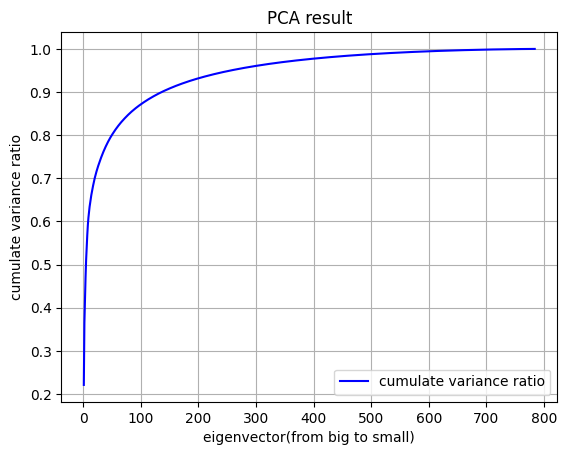

In [ ]:
### first use PCA to select features
### first use PCA to select low base feature
from sklearn.decomposition import PCA
p_model=PCA()
#p_model.fit(np.r_[center_train,center_test])
p_model.fit(np.r_[normal_x_train,normal_x_test])
variance_c_ratio=np.cumsum(p_model.explained_variance_)/np.sum(p_model.explained_variance_)
for i in range(1,variance_c_ratio.shape[0]):
  if variance_c_ratio[i-1]<=0.98 and variance_c_ratio[i]>0.98:
    use_index=i
    break
##

print(f'The number of eignevector for cumulated 98% variance is :{use_index+1}, stop at eigenvalue: {p_model.explained_variance_[i]}')
plt.plot(np.array([i for i in range(1,p_model.explained_variance_.shape[0]+1)]), variance_c_ratio,'-b',label='cumulate variance ratio')
plt.xlabel('eigenvector(from big to small)')
plt.ylabel('cumulate variance ratio')
plt.title('PCA result')
plt.legend()
plt.grid()
plt.show()


In [ ]:
### create new transfer train and test dataset: 421 eigenfeatures
p_n_model=PCA(n_components=421)

#new_train=p_n_model.fit_transform(center_train)
new_train=p_n_model.fit_transform(normal_x_train)
new_test=p_n_model.fit_transform(normal_x_test)
#new_test=p_n_model.fit_transform(center_test)
#new_test=p_n_model.fit_transform(X_test)
print(f'New train set shape:{new_train.shape},New test set shape:{new_test.shape}')

New train set shape:(60000, 421),New test set shape:(10000, 421)


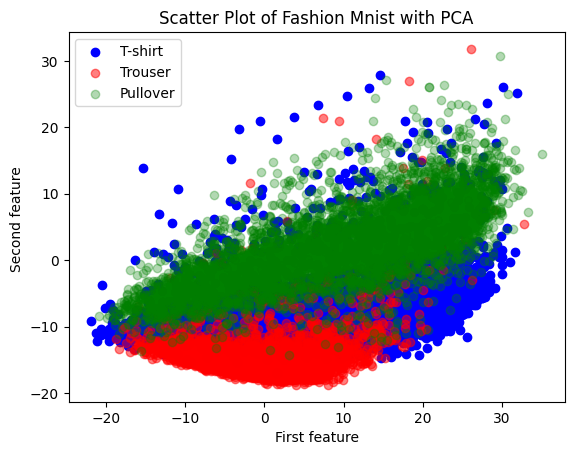

In [ ]:
### scatter plot after PCA on the first two features
plt.scatter(new_train[:,0][labels_train==0],new_train[:,1][labels_train==0],color='blue',alpha=1,label='T-shirt')
plt.scatter(new_train[:,0][labels_train==1],new_train[:,1][labels_train==1],color='red',alpha=0.5,label='Trouser')
plt.scatter(new_train[:,0][labels_train==2],new_train[:,1][labels_train==2],color='green',alpha=0.3,label='Pullover')
plt.xlabel('First feature')
plt.ylabel('Second feature ')
plt.title('Scatter Plot of Fashion Mnist with PCA')
plt.legend()
plt.show()

In [ ]:

### separate training dataset into training part and validation set
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_val, y_train, y_val = train_test_split(new_train, labels_train, test_size=0.3,random_state=100,stratify=labels_train)
print(f'x_train shape:{x_train.shape},x_validation shape:{x_val.shape}')
print(f'y_train shape:{y_train.shape},y_validation shape:{y_val.shape}')
for i in range(10):
  print(f'train set with: {np.where(y_train==i)[0].shape[0]} class {i}')
  print(f'validation set with:{np.where(y_val==i)[0].shape[0]} class {i}')

x_train shape:(42000, 421),x_validation shape:(18000, 421)
y_train shape:(42000,),y_validation shape:(18000,)
train set with: 4200 class 0
validation set with:1800 class 0
train set with: 4200 class 1
validation set with:1800 class 1
train set with: 4200 class 2
validation set with:1800 class 2
train set with: 4200 class 3
validation set with:1800 class 3
train set with: 4200 class 4
validation set with:1800 class 4
train set with: 4200 class 5
validation set with:1800 class 5
train set with: 4200 class 6
validation set with:1800 class 6
train set with: 4200 class 7
validation set with:1800 class 7
train set with: 4200 class 8
validation set with:1800 class 8
train set with: 4200 class 9
validation set with:1800 class 9


In [ ]:
## use the whole validation set to do GridsearchCV to find best K
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search=grid.fit(x_val, y_val)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
### print the best n_neightbors based on GridSearchCV
print(grid_search.best_params_)

{'n_neighbors': 6}


In [ ]:
### therefore, we choose n_neightbors=6,weight=unifrom(default),distance metric is p=2
knn_best=KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_best.fit(x_train,y_train)
score_train=knn_best.score(x_train,y_train)
score_test=knn_best.score(new_test,labels_test)
prediction=knn_best.predict(new_test)
print(f'The final training loss:{1-score_train},final testing loss:{1-score_test}')
print(f'Final training accuracy:{score_train},final testing acccuracy:{score_test}')


The final training loss:0.1051428571428571,final testing loss:0.31379999999999997
Final training accuracy:0.8948571428571429,final testing acccuracy:0.6862


In [ ]:
### calculate the precesion recall
def PR_met(k,label_true,label_predict):
  precision_list=[]
  recall_list=[]
  f1_list=[]
  for i in range(k):
    tp_number=np.sum(label_true[label_predict==i]==i)
    fp_number=np.sum(label_true[label_predict==i]!=i)
    fn_number=np.sum(label_true[label_predict!=i]==i)
    precision_i=tp_number/(tp_number+fp_number)
    recall_i=tp_number/(tp_number+fn_number)
    f1_i=2 * (precision_i * recall_i) / (precision_i + recall_i)
    precision_list.append(precision_i)
    recall_list.append(recall_i)
    f1_list.append(f1_i)
  return (np.mean(precision_list),np.mean(recall_list),np.mean(f1_list))
###


In [ ]:
pca_precision,pca_recall,pca_f1=PR_met(10,labels_test,prediction)
print(f'The average precision is :{pca_precision}, average recall is: {pca_recall}, average f1 score is {pca_f1}')

The average precision is :0.7217892852633676, average recall is: 0.6861999999999999, average f1 score is 0.6750643048680257


In [ ]:
### create the confusion matrix
mat=confusion_matrix(labels_test,prediction)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'T-shirt'),
  Text(1.5, 0, 'Trouser'),
  Text(2.5, 0, 'Pullover'),
  Text(3.5, 0, 'Dress'),
  Text(4.5, 0, 'Coat'),
  Text(5.5, 0, 'Sandal'),
  Text(6.5, 0, 'Shirt'),
  Text(7.5, 0, 'Sneaker'),
  Text(8.5, 0, 'Bag'),
  Text(9.5, 0, 'Ankle boot')])

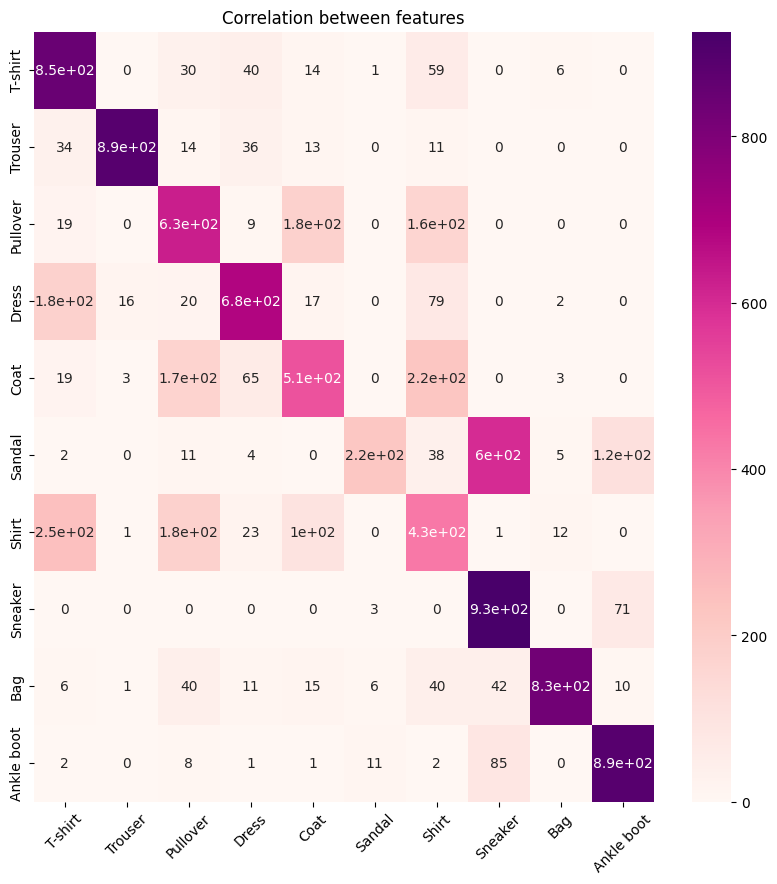

In [ ]:
label_list=['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.subplots(figsize=(10,10))
sns.heatmap(mat,annot=True,cmap='RdPu',xticklabels=label_list,yticklabels=label_list)
plt.title('Correlation between features')
plt.xticks(rotation=45)

In [ ]:
### retuslt try without PCA
train_try_x, test_try_x, train_try_y, test_try_y = train_test_split(normal_x_train, labels_train, test_size=0.3,random_state=100,stratify=labels_train)
## use the whole validation set to do GridsearchCV to find best K
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
# defining parameter range
grid_no = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search_no=grid.fit(test_try_x, test_try_y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
### print the best n_neightbors based on GridSearchCV
print(grid_search_no.best_params_)

{'n_neighbors': 6}


In [ ]:
knn_best_no=KNeighborsClassifier(n_neighbors=6)
knn_best_no.fit(train_try_x,train_try_y)
score_train_no=knn_best_no.score(train_try_x,train_try_y)
score_test_no=knn_best_no.score(X_test,labels_test)
prediction_no=knn_best_no.predict(X_test)
print(f'The final training loss:{1-score_train_no},final testing loss:{1-score_test_no}')
print(f'Final training accuracy:{score_train_no},final testing acccuracy:{score_test_no}')


The final training loss:0.10842857142857143,final testing loss:0.7369
Final training accuracy:0.8915714285714286,final testing acccuracy:0.2631


In [ ]:

pca_precision,pca_recall,pca_f1=PR_met(10,labels_test,prediction_no)
print(f'The average precision is :{pca_precision}, average recall is: {pca_recall}, average f1 score is {pca_f1}')

The average precision is :nan, average recall is: 0.2631, average f1 score is nan


<ipython-input-39-f64a06b36a95>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_i=tp_number/(tp_number+fp_number)


In [ ]:
### create the confusion matrix (no_PCA)
mat_no=confusion_matrix(labels_test,prediction_no)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'T-shirt'),
  Text(1.5, 0, 'Trouser'),
  Text(2.5, 0, 'Pullover'),
  Text(3.5, 0, 'Dress'),
  Text(4.5, 0, 'Coat'),
  Text(5.5, 0, 'Sandal'),
  Text(6.5, 0, 'Shirt'),
  Text(7.5, 0, 'Sneaker'),
  Text(8.5, 0, 'Bag'),
  Text(9.5, 0, 'Ankle boot')])

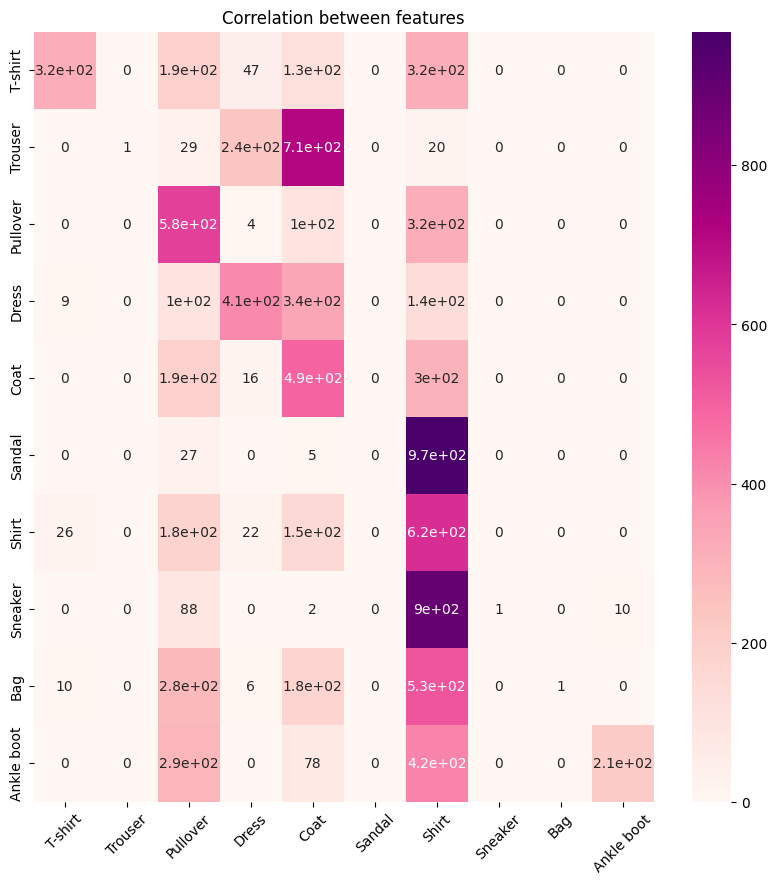

In [ ]:
### Really bed prediction
label_list=['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.subplots(figsize=(10,10))
sns.heatmap(mat_no,annot=True,cmap='RdPu',xticklabels=label_list,yticklabels=label_list)
plt.title('Correlation between features')
plt.xticks(rotation=45)

In [ ]:
normal_x_train.shape

(60000, 784)

In [ ]:
### reduce to 9 features to preserve more information of images
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDS
lds_model=LDS(n_components=9)
lds_model.fit(normal_x_train,labels_train)
Result_whole_mat=lds_model.transform(np.r_[normal_x_train,normal_x_test])
lds_train=Result_whole_mat[:60000,:]
lds_test=Result_whole_mat[60000:,:]

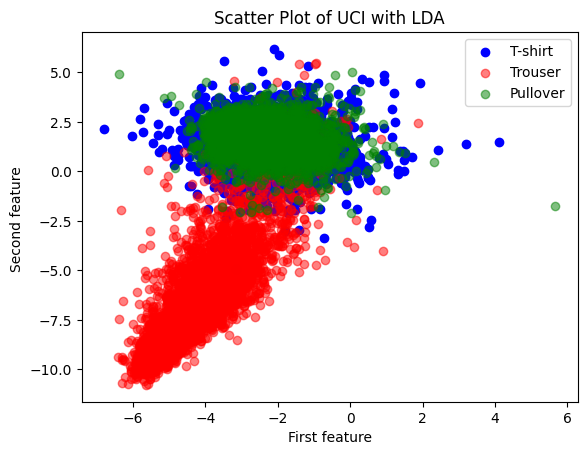

In [ ]:
plt.scatter(lds_train[:,0][labels_train==0],lds_train[:,1][labels_train==0],color='blue',alpha=1,label='T-shirt')
plt.scatter(lds_train[:,0][labels_train==1],lds_train[:,1][labels_train==1],color='red',alpha=0.5,label='Trouser')
plt.scatter(lds_train[:,0][labels_train==2],lds_train[:,1][labels_train==2],color='green',alpha=0.5,label='Pullover')
plt.xlabel('First feature')
plt.ylabel('Second feature ')
plt.title('Scatter Plot of UCI with LDA')
plt.legend()
plt.show()

In [ ]:
### still use GridSearch CV to find best k
### separate training dataset into training part and validation set
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train_lds, x_val_lds, y_train_lds, y_val_lds = train_test_split(lds_train, labels_train, test_size=0.3,random_state=100,stratify=labels_train)
print(f'x_train lds shape:{x_train_lds.shape},x_validation shape:{x_val_lds.shape}')
print(f'y_train lds shape:{y_train_lds.shape},y_validation shape:{y_val_lds.shape}')


x_train lds shape:(42000, 9),x_validation shape:(18000, 9)
y_train lds shape:(42000,),y_validation shape:(18000,)


In [ ]:
## use the whole validation set to do GridsearchCV to find best K
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
# defining parameter range
grid_lds = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search_lds=grid.fit(x_val_lds, y_val_lds)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
### print the best n_neightbors based on GridSearchCV
print(grid_search_lds.best_params_)

{'n_neighbors': 19}


In [ ]:
### therefore, we choose n_neightbors=15,weight=unifrom(default),distance metric is p=2
knn_best_lds=KNeighborsClassifier(n_neighbors=grid_search_lds.best_params_['n_neighbors'])
knn_best_lds.fit(x_train_lds,y_train_lds)
score_train_lds=knn_best_lds.score(x_train_lds,y_train_lds)
score_test_lds=knn_best_lds.score(lds_test,labels_test)
prediction_lds=knn_best_lds.predict(lds_test)
print(f'The final training loss:{1-score_train_lds},final testing loss:{1-score_test_lds}')
print(f'Final training accuracy:{score_train_lds},final testing acccuracy:{score_test_lds}')


The final training loss:0.14064285714285718,final testing loss:0.16800000000000004
Final training accuracy:0.8593571428571428,final testing acccuracy:0.832


In [ ]:
### create the confusion matrix (no_PCA)
mat_lds=confusion_matrix(labels_test,prediction_lds)

In [ ]:
lds_precision,lds_recall,lds_f1=PR_met(10,labels_test,prediction_lds)
print(f'The average precision for lds is :{lds_precision}, average recall for lds is: {lds_recall}, average f1 score for lds is {lds_f1}')

The average precision for lds is :0.8304222219624787, average recall for lds is: 0.8320000000000001, average f1 score for lds is 0.8297638738368749


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'T-shirt'),
  Text(1.5, 0, 'Trouser'),
  Text(2.5, 0, 'Pullover'),
  Text(3.5, 0, 'Dress'),
  Text(4.5, 0, 'Coat'),
  Text(5.5, 0, 'Sandal'),
  Text(6.5, 0, 'Shirt'),
  Text(7.5, 0, 'Sneaker'),
  Text(8.5, 0, 'Bag'),
  Text(9.5, 0, 'Ankle boot')])

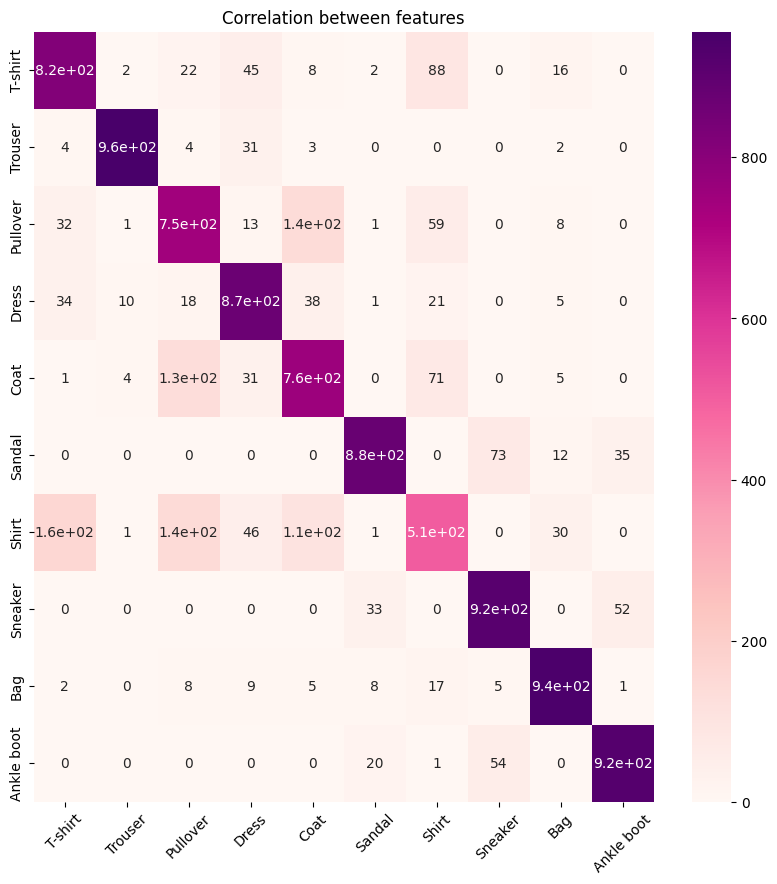

In [ ]:
###
label_list=['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.subplots(figsize=(10,10))
sns.heatmap(mat_lds,annot=True,cmap='RdPu',xticklabels=label_list,yticklabels=label_list)
plt.title('Correlation between features')
plt.xticks(rotation=45)